In [1]:
# Install dependencies required specifically for this experiment

# !pip install transformers geopandas

In [2]:
import sys
sys.path.append("../../")

In [3]:
import requests
import json
import pandas as pd
# import plotly.express as px
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import torch

from transformers import pipeline

from inFairness import distances
from inFairness.postprocessing import GraphLaplacianIF

# Import data loading script
import data

In [4]:
EMBEDPATH = 'data/embeddings/glove.42B.300d.txt'
NYC_NAMES_PATH = 'data/names/Popular_Baby_Names.csv'

In [5]:
embeddings = data.load_embeddings(EMBEDPATH)
nyc_names_embed = data.load_nyc_names(NYC_NAMES_PATH, embeddings)

In [6]:
posneg_template="This movie is "
posneg_sentences = data.get_positive_negative_sents(posneg_template)

print(posneg_sentences[:3])

['This movie is remarkable', 'This movie is magnificent', 'This movie is wondrous']


In [7]:
classifier = pipeline("sentiment-analysis")

distance_x = distances.SVDSensitiveSubspaceDistance()
distance_x.fit(nyc_names_embed, n_components=50)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [8]:
url = 'https://datahub.io/core/geo-countries/r/countries.geojson'
geodf = geopandas.read_file(url)

countries = set()
country_sentences = []

template = f"This movie was filmed in"

for _, row in geodf.iterrows():
    country_name = row["ADMIN"]
    countries.add(country_name)
    country_sentences.append((country_name, f"{template.strip()} {country_name}"))

In [9]:
sentence_embeddings = []
final_sentences = []
countries = []

print("Embedding sentences with explicit sentiment")
for sentence in posneg_sentences:
    try:
        embeds = data.embed_sentence(sentence, embeddings)
    except:
        pass
    else:
        sentence_embeddings.append(embeds)
        final_sentences.append(sentence)


print("Embedding country sentences")
for country, sentence in country_sentences:
    try:
        embeds = data.embed_sentence(sentence, embeddings)
    except:
        pass
    else:
        sentence_embeddings.append(embeds)
        final_sentences.append(sentence)
        countries.append(country)
        
        
sentence_embeddings = torch.cat(sentence_embeddings, dim=0)

Embedding sentences with explicit sentiment
Embedding country sentences


In [10]:
def result_to_prob_score(result):
    if result["label"] == "POSITIVE":
        return (1 - result["score"], result["score"])
    else:
        return (result["score"], 1 - result["score"])

    
results = classifier(final_sentences)
probas = list(map(result_to_prob_score, results))

In [11]:
country_preds = probas[-len(countries):]
country_preds = [x[1] for x in country_preds]

preds_df = pd.DataFrame({
    "country": countries,
    "positive_prob": country_preds
})

preds_df.head()

,country,positive_prob
0,Aruba,0.868730
1,Afghanistan,0.077288
2,Angola,0.111094
3,Anguilla,0.817107
4,Albania,0.979248


In [12]:
plotdf = geodf.merge(preds_df, how="right", left_on="ADMIN", right_on="country")
plotdf.head()

,ADMIN,ISO_A3,geometry,country,positive_prob
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",Aruba,0.868730
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",Afghanistan,0.077288
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",Angola,0.111094
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",Anguilla,0.817107
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",Albania,0.979248


<AxesSubplot:title={'center':'Positive class probability of sentences: "This movie was filmed in <country>"'}>

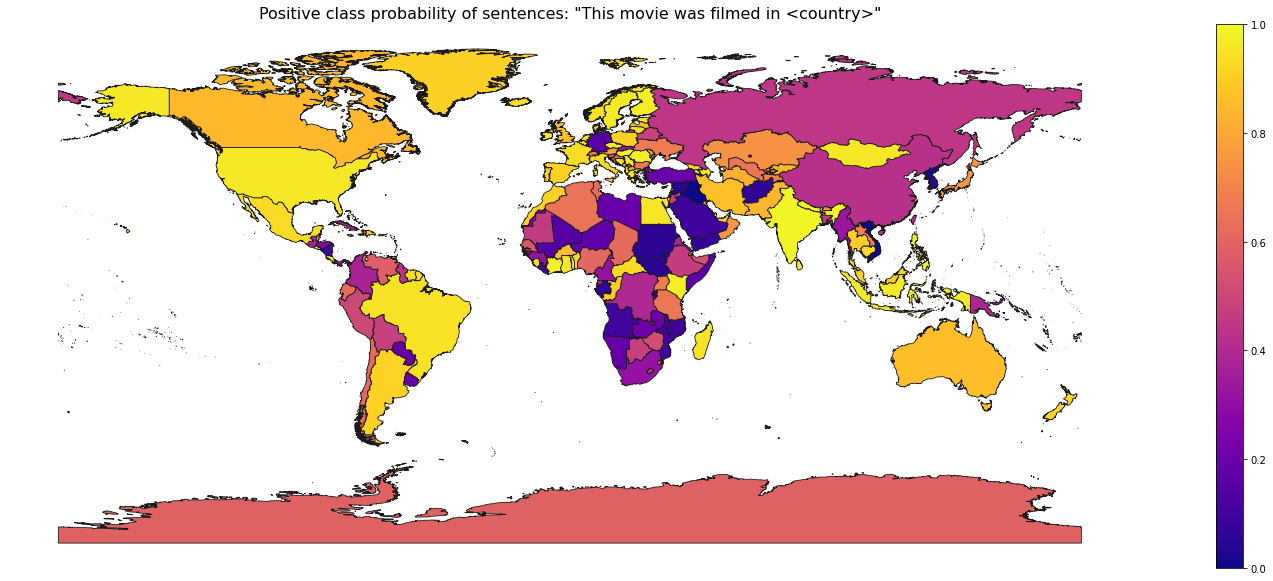

In [13]:
vmin, vmax = 0, 1.0
cmap = "plasma"

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(f'Positive class probability of sentences: "{template} <country>"', fontdict={'fontsize': '16'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# add the colorbar to the figure
fig.colorbar(sm)

plotdf.plot(column="positive_prob", ax=ax, linewidth=0.8, edgecolor="0.1", cmap=cmap)

In [14]:
infair_postprocess = GraphLaplacianIF(distance_x)

infair_postprocess.add_datapoints(
    X=sentence_embeddings, y=torch.Tensor(probas)
)

probas_processed = infair_postprocess.postprocess(
    lambda_param=1.0, scale=1.0, threshold=1e10, normalize=False
)

In [15]:
country_preds = probas_processed[-len(countries):]
country_preds = [x[1].item() for x in country_preds]

preds_df = pd.DataFrame({
    "country": countries,
    "positive_prob": country_preds
})

preds_df.head()

,country,positive_prob
0,Aruba,0.709781
1,Afghanistan,0.695171
2,Angola,0.698124
3,Anguilla,0.708529
4,Albania,0.713388


In [16]:
plotdf = geodf.merge(preds_df, how="right", left_on="ADMIN", right_on="country")
plotdf.head()

,ADMIN,ISO_A3,geometry,country,positive_prob
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",Aruba,0.709781
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",Afghanistan,0.695171
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",Angola,0.698124
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",Anguilla,0.708529
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",Albania,0.713388


<AxesSubplot:title={'center':'Postprocessed positive class probability of sentences: "This movie was filmed in <country>"'}>

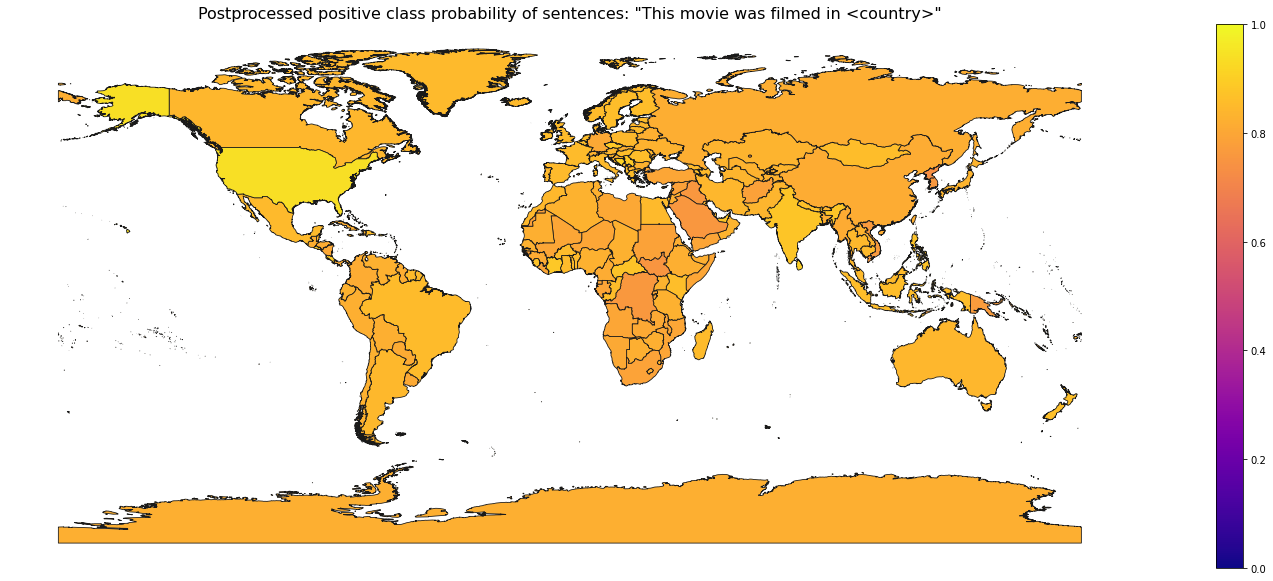

In [17]:
vmin, vmax = 0, 1.0
cmap = "plasma"

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(f'Postprocessed positive class probability of sentences: "{template} <country>"', fontdict={'fontsize': '16'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# add the colorbar to the figure
fig.colorbar(sm)

plotdf.plot(column="positive_prob", ax=ax, linewidth=0.8, edgecolor="0.1", cmap=cmap)

In [18]:
preds = [x[1] for x in probas]
preds_processed = [x[1].item() for x in probas_processed]

sent_df = pd.DataFrame({
    "sentences": final_sentences,
    "score (original)": preds,
    "score (post-processed)": preds_processed
})

sent_df

,sentences,score (original),score (post-processed)
0,This movie is remarkable,0.999881,0.815712
1,This movie is magnificent,0.999883,0.838973
2,This movie is wondrous,0.999879,0.833016
3,This movie is amazing,0.999884,0.823027
4,This movie is astounding,0.999864,0.814547
...,...,...,...
468,This movie was filmed in Samoa,0.862637,0.709190
469,This movie was filmed in Yemen,0.079280,0.697393
470,This movie was filmed in South Africa,0.320346,0.696815
471,This movie was filmed in Zambia,0.214546,0.700614


In [19]:
def print_predictions(sentence_list):
    
    df = sent_df[sent_df['sentences'].isin(sentence_list)]
    
    for _, row in df.iterrows():
        
        print('\n' + '-'*100 + '\n')
        print('Sentence: ' + row['sentences'])
        print(f'Original score: ' + str(row['score (original)']))
        print(f'Post-processed score: ' + str(row['score (post-processed)']))

In [20]:
sentlist = ['This movie is wondrous', 'This movie is astounding']

print_predictions(sentlist)


----------------------------------------------------------------------------------------------------

Sentence: This movie is wondrous
Original score: 0.9998786449432373
Post-processed score: 0.8330156803131104

----------------------------------------------------------------------------------------------------

Sentence: This movie is astounding
Original score: 0.9998641014099121
Post-processed score: 0.8145469427108765
